# Sheet 8 - Stochastic Optimization

Team name: DataFun

Members:

Fabian Frank
Jan Botsch
David Munkacsi

In [1]:
import numpy as np
import itertools as itt
import matplotlib.pyplot as plt

# 8.1 Simulated Annealing

In [2]:
#returns all permutations of -1 and 1 in a set of length n
def getPermut(n):
    return np.fromiter(itt.chain.from_iterable(itt.product([1,-1], repeat=n)),int).reshape(2**n,n)

#returns the energy for a fully connected network
def calcEnergy(s, w):
    E = -0.5 * np.dot(s.T, np.dot(w, s))
    return (E)

#returns the energy for one node of the network
def calcEnergyOfElement(s,w,i):
    E = -0.5 * s[i] * np.dot(w,s)[i]
    return E

#returns the value of the partition function
def calcPartitionFunction(n,w,beta):
    s = getPermut(n)
    sum = 0
    for i in range(s.shape[0]):
        sum = sum + np.exp( -1.0 * beta * calcEnergy(s[i,:],w))
    return (sum)

#returns the probablity that the network is in state s
def calcProbability(s,w, beta):
    z = calcPartitionFunction(s.shape[0],w, beta)
    #print("Z=" + str(z))
    p = (1.0 / z) * np.exp( -1.0 * beta * calcEnergy(s,w))
    return (p)

## Initalization

In [3]:
#number of nodes
N = 6

#initialize the weights - make sure the diagonal is 0
W = np.random.rand(N,N)
W = (W + W.T) * 0.5
W = W - np.diag(W.diagonal())
print("Weights:" + str(W))

#initialize the state vector
S_init = np.random.choice([-1,1],6)
print("Initial state:" + str(S_init))

#initialize optimization parameters
Beta_init = 1.05
Tau = 1.05
maxIter = 50
M = np.array([1, 500])

#init arrays for storying development of energy and beta
arrBeta = np.zeros([M.shape[0], maxIter])
arrE = np.zeros([M.shape[0], maxIter])

Weights:[[ 0.          0.34527921  0.87458968  0.57841836  0.77484152  0.45876979]
 [ 0.34527921  0.          0.4497168   0.52054455  0.67978417  0.97613691]
 [ 0.87458968  0.4497168   0.          0.4120317   0.25057862  0.18199512]
 [ 0.57841836  0.52054455  0.4120317   0.          0.5123562   0.30200747]
 [ 0.77484152  0.67978417  0.25057862  0.5123562   0.          0.39150503]
 [ 0.45876979  0.97613691  0.18199512  0.30200747  0.39150503  0.        ]]
Initial state:[ 1 -1  1  1 -1  1]


## Optimization

In [4]:
for h in range(M.shape[0]):
    #set initial values for iteration
    m = M[h]
    S = S_init
    Beta=Beta_init
    for i in range(maxIter):
        for j in range(m):
            #select a node randomly
            idx = np.random.choice(N,1)[0]
            
            #determine the energies fot s_i and -s_i
            E_s_i = calcEnergyOfElement(S,W,idx)
            
            #calc the probability for flipping the state of S[idx]
            prob = 1.0 / (1.0 + (np.exp(Beta * -2.0 * E_s_i)))
            
            #sample the new state of S[idx]
            newValue = np.random.choice([S[idx],-1 * S[idx]],1, p=[1.0-prob, prob])[0]
            
            #assign new value
            S[idx] = newValue
    
        #record values
        arrBeta[h,i] = 1.0 / Beta
        arrE[h,i] = calcEnergy(S, W)

        #increment Beta
        Beta = Beta * Tau

## Plotting

### a) Plot temperature and Energy over iterations

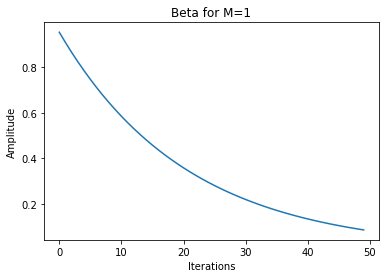

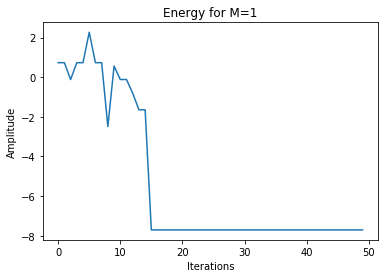

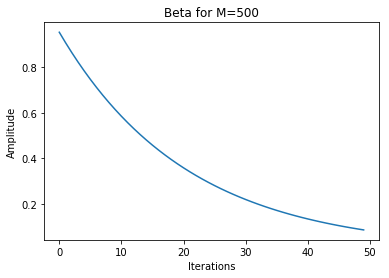

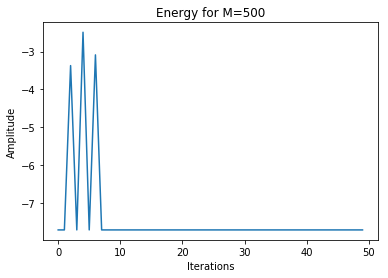

In [5]:
for h in range(M.shape[0]):
    plt.figure()
    plt.plot(arrBeta[h,:])
    plt.xlabel('Iterations')
    plt.ylabel('Amplitude')
    plt.title('Beta for M=' + str(M[h]))
    plt.figure()
    plt.plot(arrE[h,:])
    plt.xlabel('Iterations')
    plt.ylabel('Amplitude')
    plt.title('Energy for M=' + str(M[h]))
plt.show()

### b) Plot Energies for all states

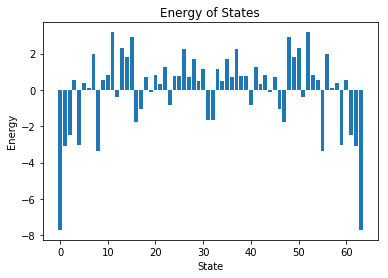

In [6]:
arrStateEnergy = np.zeros(2**N)
states = getPermut(N)
for i in range(states.shape[0]):
    arrStateEnergy[i] = calcEnergy(states[i,:], W)

plt.figure()
plt.bar(range(2**N),arrStateEnergy)
plt.xlabel('State')
plt.ylabel('Energy')
plt.title('Energy of States')

plt.show()

### Plot Probabilities of the states for different betas

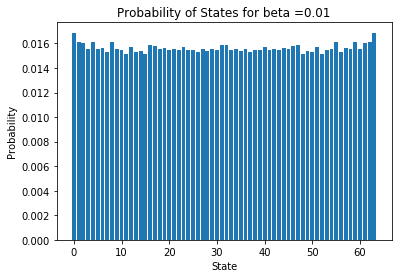

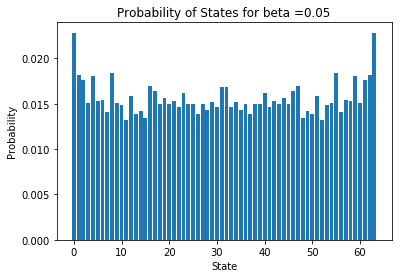

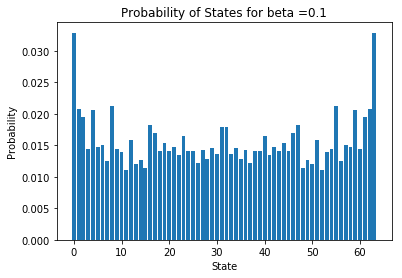

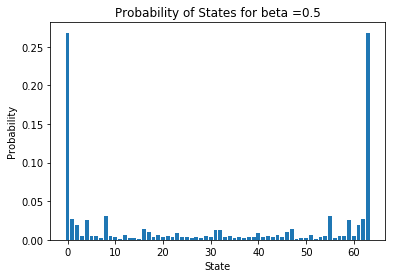

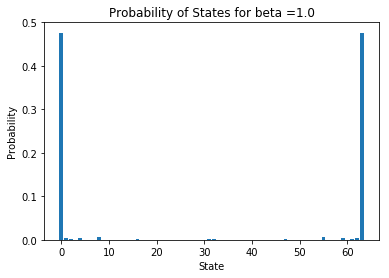

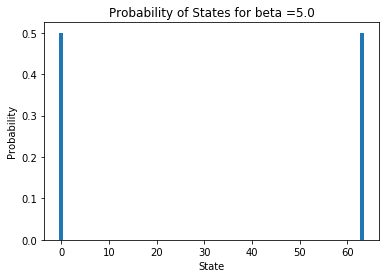

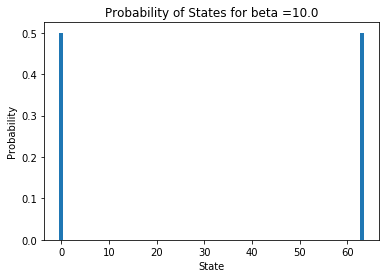

In [7]:
betas = np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0])
arrStateProbabs = np.zeros([betas.shape[0],2**N])
states = getPermut(N)
for i in range(betas.shape[0]):
    for j in range(states.shape[0]):
        arrStateProbabs[i,j] = calcProbability(states[j,:], W, betas[i])

    plt.figure()
    plt.bar(range(2**N),arrStateProbabs[i,:])
    plt.xlabel('State')
    plt.ylabel('Probability')
    plt.title('Probability of States for beta =' + str(betas[i]))

plt.show()


# 8.2 Simulated Annealing

In [8]:
numNodes = N
# 8.2 Initialization
def init(numNodes):
    beta = 0.5
    tau = 1.15
    t_max = 20
    eps = 1e-10
    state = 2 * np.random.rand(numNodes) - 1
    meanField = np.zeros([6])
    return beta, tau, t_max, eps, state, meanField

beta, tau, t_max, eps, initstate, meanField = init(numNodes)

In [12]:
# 8.2 Optimization
historyBetaEnergy = np.empty((2,0))

def calcEnergy(state):
    egy = -0.5 * np.dot(state.T, np.dot(W, state))
    return (egy)

def saveBetaAndEnergy(state):
    energy = calcEnergy(state)
    global historyBetaEnergy 
    historyBetaEnergy = np.append(historyBetaEnergy, np.asarray([beta, energy]).reshape((2,1)), axis=1)
    
def computeMeanField(state):
    for i in range(numNodes):
        e = 0
        for j in range(numNodes):
            if j != i:
                e += -W[i,j] * state[j] 
        meanField[i] = e
        state[i] = np.tanh(-beta * e)            
    ret = meanField
    return ret, state

def updateState(e):
    st = np.tanh(-beta * e)
    return st


for t in range(t_max):
    state = np.copy(initstate)
    e_new = np.zeros((numNodes))
    e_old = np.ones((numNodes)) * eps + 0.1
    counter = 0
    nor = np.linalg.norm(e_old - e_new)
    while (nor > eps ):
        e_old = np.copy(e_new)
        e_new, state = computeMeanField(state)
        saveBetaAndEnergy(state)
        counter += 1
        nor = np.linalg.norm(e_old - e_new)
    beta = beta * tau
    print("Iteration " + str(t) + " done in " + str(counter) + " steps.")

Iteration 0 done in 3 steps.
Iteration 1 done in 3 steps.
Iteration 2 done in 3 steps.
Iteration 3 done in 3 steps.
Iteration 4 done in 3 steps.
Iteration 5 done in 3 steps.
Iteration 6 done in 3 steps.
Iteration 7 done in 3 steps.
Iteration 8 done in 3 steps.
Iteration 9 done in 3 steps.
Iteration 10 done in 3 steps.
Iteration 11 done in 3 steps.
Iteration 12 done in 3 steps.
Iteration 13 done in 3 steps.
Iteration 14 done in 3 steps.
Iteration 15 done in 3 steps.
Iteration 16 done in 3 steps.
Iteration 17 done in 3 steps.
Iteration 18 done in 3 steps.
Iteration 19 done in 3 steps.


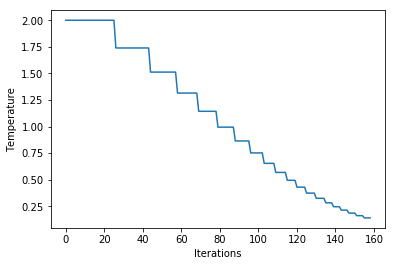

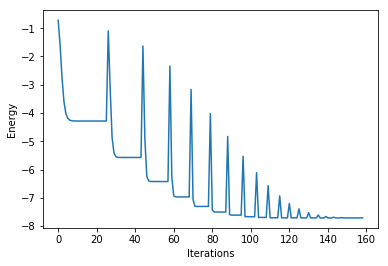

In [10]:
#Plotting
plt.figure()
plt.plot(1/historyBetaEnergy[0,:])
plt.xlabel('Iterations')
plt.ylabel('Temperature')

plt.figure()
plt.plot(historyBetaEnergy[1,:])
plt.xlabel('Iterations')
plt.ylabel('Energy')

plt.show()
